<a href="https://colab.research.google.com/github/karthikeyan5002/booleanretrieval/blob/main/CancerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ##  **Classification of Cancer**

> The dataset showes how new cases of cancer could be classified by gene
expression monitoring (via DNA microarray) and thereby provided a general approach for identifying new cancer classes and assigning tumors to known classes. These data were used to classify patients with acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL).





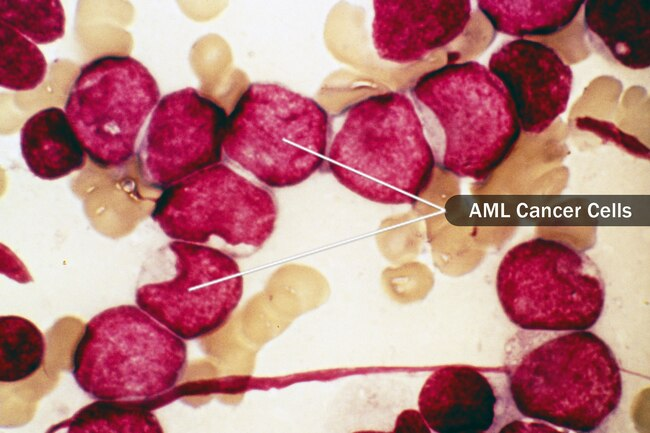

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import recall_score, precision_score, classification_report,accuracy_score,confusion_matrix, roc_curve, auc, roc_curve,accuracy_score
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from scipy import ndimage
import seaborn as sns

In [ ]:
#Load dataset
Train_Data = pd.read_csv("/content/data_set_ALL_AML_train.csv")
Test_Data = pd.read_csv("/content/data_set_ALL_AML_independent.csv")
labels = pd.read_csv("/content/actual.csv", index_col = 'patient')

In [ ]:
Train_Data.head()


,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [ ]:
#check for nulls
print(Train_Data.isna().sum().max())
print(Test_Data.isna().sum().max())

0
0


In [ ]:
#drop 'call' columns
cols = [col for col in Test_Data.columns if 'call' in col]
test = Test_Data.drop(cols, 1)
cols = [col for col in Train_Data.columns if 'call' in col]
train = Train_Data.drop(cols, 1)

<ipython-input-5-e99f01a416b9>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test = Test_Data.drop(cols, 1)
<ipython-input-5-e99f01a416b9>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train = Train_Data.drop(cols, 1)


In [ ]:
  #Join all the data
patients = [str(i) for i in range(1, 73, 1)]
df_all = pd.concat([train, test], axis = 1)[patients]

In [ ]:
#transpose rows and columns
df_all = df_all.T

In [ ]:
df_all["patient"] = pd.to_numeric(patients)
labels["cancer"]= pd.get_dummies(labels.cancer, drop_first=True)
# add the cancer column to train data

Data = pd.merge(df_all, labels, on="patient")

In [ ]:
Data.head()


,0,1,2,3,4,5,6,7,8,9,...,7121,7122,7123,7124,7125,7126,7127,7128,patient,cancer
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,-125,389,-37,793,329,36,191,-37,1,0
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,-36,442,-17,782,295,11,76,-14,2,0
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,33,168,52,1138,777,41,228,-41,3,0
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,218,174,-110,627,170,-50,126,-91,4,0
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,57,504,-26,250,314,14,56,-25,5,0


In [ ]:
Data['cancer'].value_counts()

0    47
1    25
Name: cancer, dtype: int64

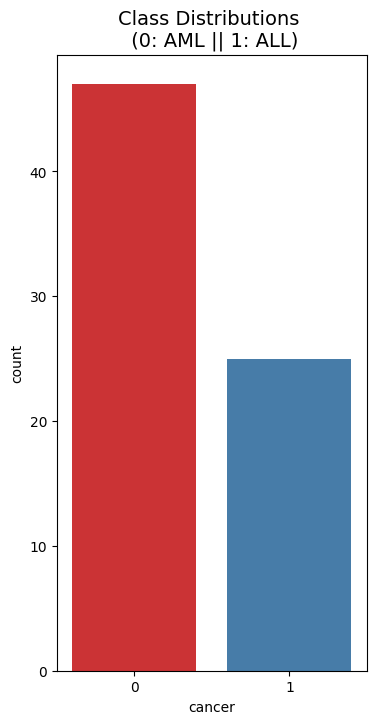

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame named 'Data' with a column 'cancer'
plt.figure(figsize=(4, 8))
colors = ["AML", "ALL"]
sns.countplot(x='cancer', data=Data, palette="Set1")
plt.title('Class Distributions \n (0: AML || 1: ALL)', fontsize=14)
plt.show()


In [ ]:
#X -> matrix of independent variable
#y -> vector of dependent variable
X, y = Data.drop(columns=["cancer"]), Data["cancer"]

In [ ]:
X


,0,1,2,3,4,5,6,7,8,9,...,7120,7121,7122,7123,7124,7125,7126,7127,7128,patient
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,511,-125,389,-37,793,329,36,191,-37,1
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,837,-36,442,-17,782,295,11,76,-14,2
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,1199,33,168,52,1138,777,41,228,-41,3
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,835,218,174,-110,627,170,-50,126,-91,4
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,649,57,504,-26,250,314,14,56,-25,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-154,-136,49,180,-257,-273,141,-123,52,878,...,540,13,1075,-45,524,249,40,-68,-1,68
68,-79,-118,-30,68,-110,-264,-28,-61,40,-217,...,617,-34,738,11,742,234,72,109,-30,69
69,-55,-44,12,129,-108,-301,-222,-133,136,320,...,318,35,241,-66,320,174,-4,176,40,70
70,-59,-114,23,146,-171,-227,-73,-126,-6,149,...,760,-38,201,-55,348,208,0,74,-12,71


In [ ]:
y


0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Name: cancer, Length: 72, dtype: uint8

In [ ]:
from sklearn.model_selection import train_test_split
#split the dataset
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size = 0.25, random_state= 0)

In [ ]:
#before feature scaling
#X_train = pd.DataFrame(X_train)
#X_train.plot(kind="kde", legend=None)

In [35]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)


In [37]:
#feature scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [ ]:
X_train.shape


(54, 7130)

In [38]:
#after feature scaling
#X_train = pd.DataFrame(X_train)
#X_train.plot(kind="kde", legend=None)

38 features explain around 90% of the variance. From 7129 features to 38, not too bad.


<BarContainer object of 38 artists>

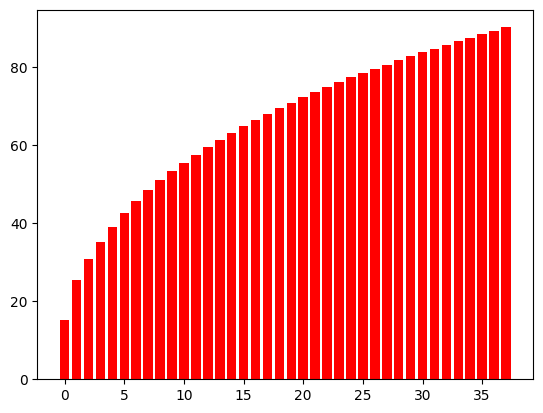

In [39]:
pca = PCA()
pca.fit_transform(X_train)

total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1

print(k, " features explain around 90% of the variance. From 7129 features to ", k, ", not too bad.", sep='')

pca = PCA(n_components=k)
X_train_pca = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp,color = 'r')

In [40]:
pca.n_components_


38

In [41]:
from mpl_toolkits.mplot3d import Axes3D

pca3 = PCA(n_components=3).fit(X_train)
X_train_reduced = pca3.transform(X_train)

plt.clf()
fig = plt.figure(1, figsize=(10,6))
ax = Axes3D(fig, elev=-150, azim=110,)
ax.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], X_train_reduced[:, 2], c = y_train, cmap='coolwarm', linewidths=10)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])


<ipython-input-41-423fc48f43bd>:12: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_ticklabels([])
<ipython-input-41-423fc48f43bd>:14: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_ticklabels([])
<ipython-input-41-423fc48f43bd>:16: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_ticklabels([])


[Text(-60.0, 0, ''),
 Text(-40.0, 0, ''),
 Text(-20.0, 0, ''),
 Text(0.0, 0, ''),
 Text(20.0, 0, ''),
 Text(40.0, 0, ''),
 Text(60.0, 0, ''),
 Text(80.0, 0, ''),
 Text(100.0, 0, '')]

<Figure size 640x480 with 0 Axes>

In [42]:
from sklearn.utils import resample
from collections import Counter

print("Before Upsampling:-")
print(Counter(y_train))


# Let's use SMOTE to oversample
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train_ov, y_train_ov = oversample.fit_resample(X_train_pca,y_train)

print("After Upsampling:-")
print(Counter(y_train_ov))

Before Upsampling:-
Counter({0: 39, 1: 15})
After Upsampling:-
Counter({0: 39, 1: 39})


In [43]:
# do a grid search
svc_params = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]

search = GridSearchCV(SVC(), svc_params, n_jobs=-1, verbose=1)
search.fit(X_train_ov, y_train_ov)

best_accuracy = search.best_score_ #to get best score
best_parameters = search.best_params_ #to get best parameters
# select best svc
best_svc = search.best_estimator_
best_svc

Fitting 5 folds for each of 40 candidates, totalling 200 fits


SVC(C=1, kernel='linear')

The accuracy of SVM is 0.7222222222222222

Classification report :
               precision    recall  f1-score   support

           0       0.62      1.00      0.76         8
           1       1.00      0.50      0.67        10

    accuracy                           0.72        18
   macro avg       0.81      0.75      0.71        18
weighted avg       0.83      0.72      0.71        18



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

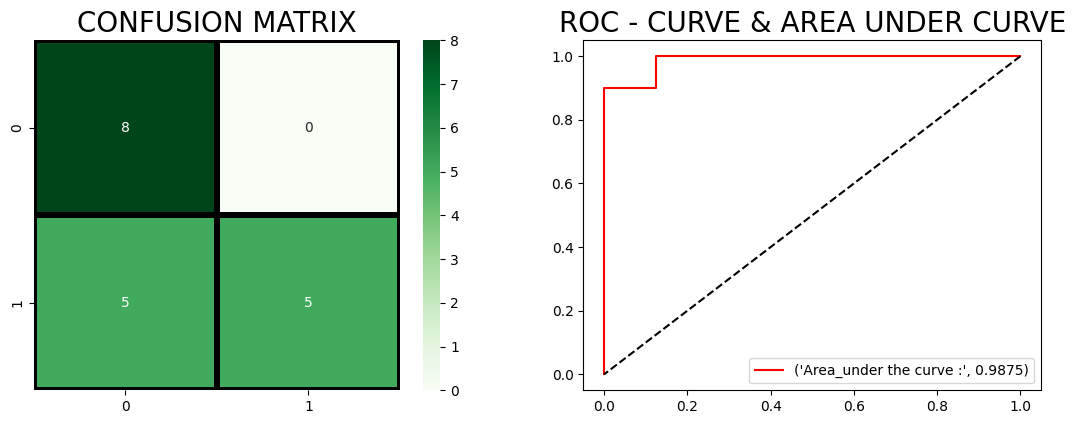

In [44]:
#build SVM model with best parameters
svc_model = SVC(C=1, kernel='linear',probability=True)

svc_model.fit(X_train_ov, y_train_ov)

prediction=svc_model.predict(X_test_pca)

acc_svc = accuracy_score(prediction,y_test)
print('The accuracy of SVM is', acc_svc)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True, cmap='Greens', fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = svc_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

In [45]:
knn_param = {
    "n_neighbors": [i for i in range(1,30,5)],
    "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree", "brute"],
    "leaf_size": [1, 10, 30],
    "p": [1,2]
}
search = GridSearchCV(KNeighborsClassifier(), knn_param, n_jobs=-1, verbose=1)
search.fit(X_train_ov, y_train_ov)

best_accuracy = search.best_score_ #to get best score
best_parameters = search.best_params_ #to get best parameters
# select best svc
best_knn = search.best_estimator_
best_knn

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, n_neighbors=6)

The accuracy of K-NN is 0.6111111111111112

Classification report :
               precision    recall  f1-score   support

           0       0.55      0.75      0.63         8
           1       0.71      0.50      0.59        10

    accuracy                           0.61        18
   macro avg       0.63      0.62      0.61        18
weighted avg       0.64      0.61      0.61        18



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

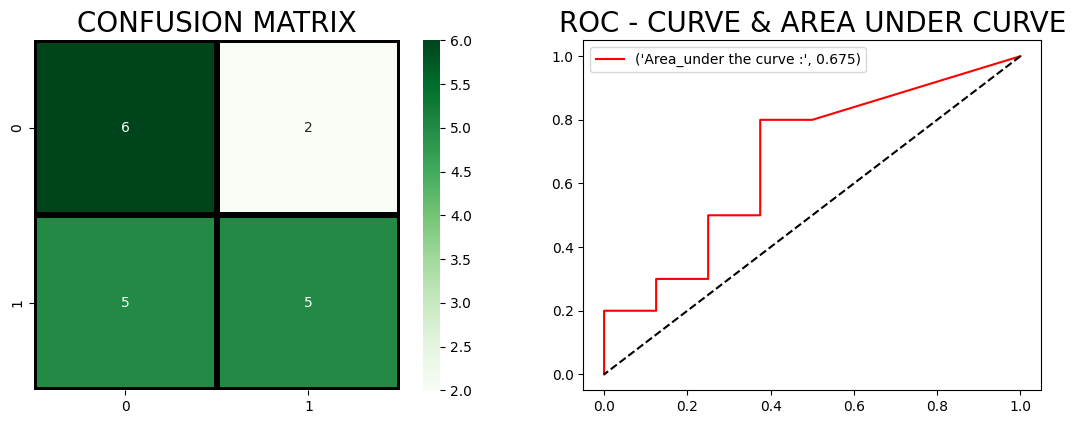

In [46]:
knn_model = KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, n_neighbors=6,
                     weights='distance')

knn_model.fit(X_train_ov,y_train_ov)
prediction=knn_model.predict(X_test_pca)

acc_knn = accuracy_score(prediction,y_test)
print('The accuracy of K-NN is', acc_knn)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True, cmap='Greens', fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = knn_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

In [47]:
log_grid = {'C': [1e-03, 1e-2, 1e-1, 1, 10],
                 'penalty': ['l1', 'l2']}

log_model = GridSearchCV(estimator=LogisticRegression(solver='liblinear'),
                  param_grid=log_grid,
                  cv=3,
                  scoring='accuracy')
log_model.fit(X_train_ov, y_train_ov)


best_accuracy = log_model.best_score_ #to get best score
best_parameters = log_model.best_params_ #to get best parameters
# select best svc
best_lr = log_model.best_estimator_
best_lr

LogisticRegression(C=0.001, solver='liblinear')

Validation accuracy of Logistic Regression is 0.8333333333333334

Classification report :
               precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.77      1.00      0.87        10

    accuracy                           0.83        18
   macro avg       0.88      0.81      0.82        18
weighted avg       0.87      0.83      0.82        18



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

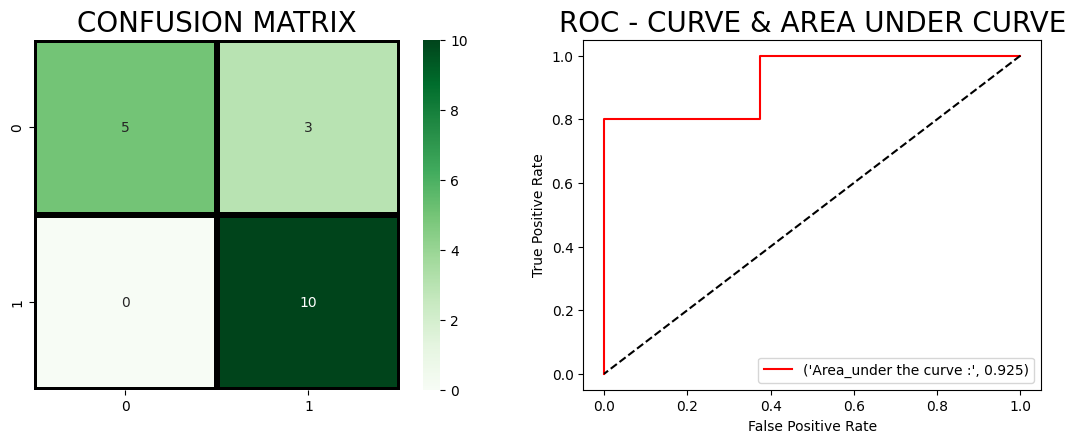

In [48]:
#Logistic Regression
lr_model = LogisticRegression(C=0.001, solver='liblinear')

lr_model.fit(X_train_ov,y_train_ov)

prediction=lr_model.predict(X_test_pca)

acc_log = accuracy_score(prediction,y_test)
print('Validation accuracy of Logistic Regression is', acc_log)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="Greens",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = lr_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

In [49]:
params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4, 5, 6], 'max_depth':[3,4,5,6,7,8]}
decision_search = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

decision_search.fit(X_train_ov, y_train_ov)


best_accuracy = decision_search.best_score_ #to get best score
best_parameters = decision_search.best_params_ #to get best parameters
# select best svc
best_ds = decision_search.best_estimator_
best_ds


Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


DecisionTreeClassifier(max_depth=3, max_leaf_nodes=4, random_state=42)

Validation accuracy of Decision Tree is 0.6111111111111112

Classification report :
               precision    recall  f1-score   support

           0       0.53      1.00      0.70         8
           1       1.00      0.30      0.46        10

    accuracy                           0.61        18
   macro avg       0.77      0.65      0.58        18
weighted avg       0.79      0.61      0.57        18



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

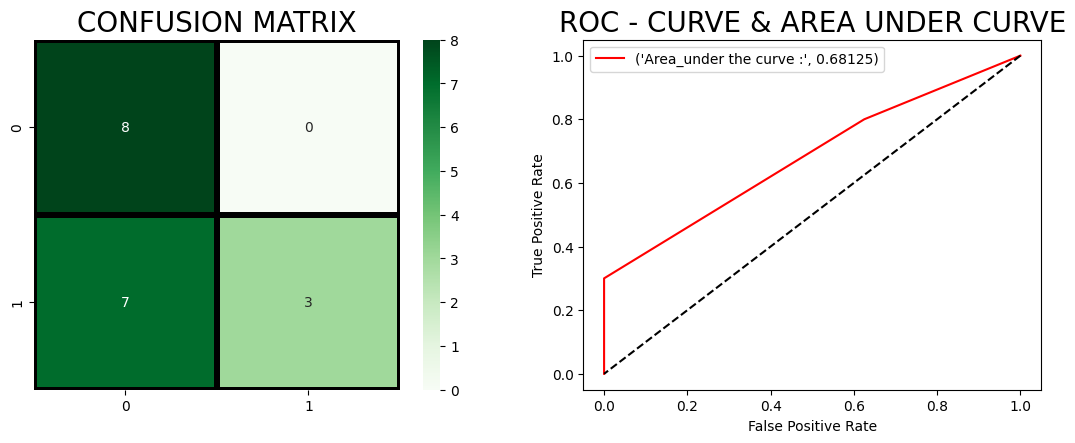

In [50]:
#Decision Tree
ds_model = DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3, random_state=42)

ds_model.fit(X_train_ov,y_train_ov)

prediction=ds_model.predict(X_test_pca)

acc_decision_tree = accuracy_score(prediction,y_test)
print('Validation accuracy of Decision Tree is', acc_decision_tree)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="Greens",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = ds_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

In [52]:
# Hyperparameters search grid
rf_param_grid = {'bootstrap': [False, True],
         'n_estimators': [60, 70, 80, 90, 100],
         'max_features': [0.6, 0.65, 0.7, 0.75, 0.8],
         'min_samples_leaf': [8, 10, 12, 14],
         'min_samples_split': [3, 5, 7]
        }

# Create the GridSearchCV object
rf_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_param_grid, cv=3, scoring='accuracy')
rf_search.fit(X_train_ov, y_train_ov)

best_accuracy = rf_search.best_score_ #to get best score
best_parameters = rf_search.best_params_ #to get best parameters
# select best svc
best_rf = rf_search.best_estimator_
best_rf

RandomForestClassifier(max_features=0.65, min_samples_leaf=8,
                       min_samples_split=5)

Validation accuracy of RandomForest Classifier is 0.5555555555555556

Classification report :
               precision    recall  f1-score   support

           0       0.50      0.75      0.60         8
           1       0.67      0.40      0.50        10

    accuracy                           0.56        18
   macro avg       0.58      0.57      0.55        18
weighted avg       0.59      0.56      0.54        18



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

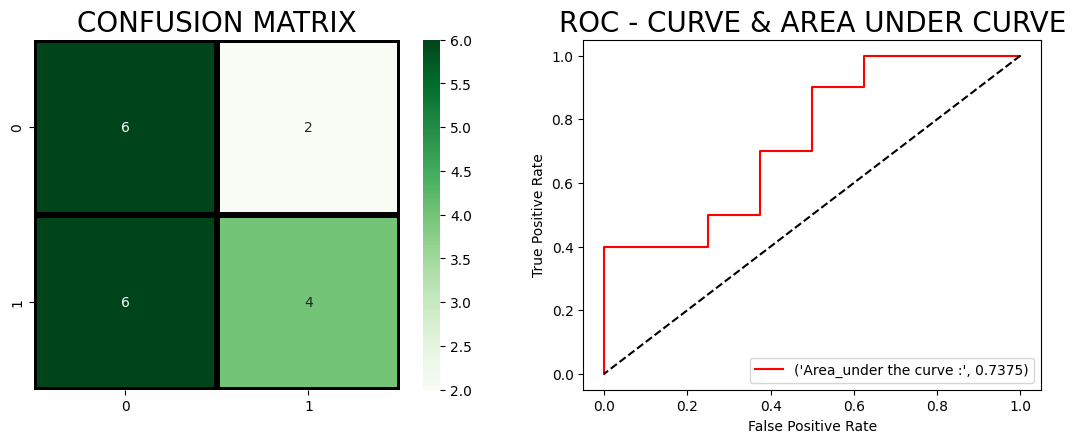

In [53]:
#Random forest
rf_model = RandomForestClassifier(bootstrap=False, max_features=0.6, min_samples_leaf=8,
                       min_samples_split=3, n_estimators=70)

rf_model.fit(X_train_ov,y_train_ov)

prediction=rf_model.predict(X_test_pca)

acc_random_forest = accuracy_score(prediction,y_test)
print('Validation accuracy of RandomForest Classifier is', acc_random_forest)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="Greens",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = rf_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)


In [54]:
xgb_grid_params = {'max_depth': [3, 4, 5, 6, 7, 8, 10, 12],
               'min_child_weight': [1, 2, 4, 6, 8, 10, 12, 15],
               'n_estimators': [40, 50, 60, 70, 80, 90, 100, 110, 120, 130],
               'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]}

# Create the GridSearchCV object
xgb_search = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=xgb_grid_params, cv=3, scoring='accuracy')
xgb_search.fit(X_train_ov, y_train_ov)

best_accuracy = xgb_search.best_score_ #to get best score
best_parameters = xgb_search.best_params_ #to get best parameters
# select best svc
best_xgb = xgb_search.best_estimator_
best_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=80, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Validation accuracy of XG Boost is 0.6111111111111112

Classification report :
               precision    recall  f1-score   support

           0       0.53      1.00      0.70         8
           1       1.00      0.30      0.46        10

    accuracy                           0.61        18
   macro avg       0.77      0.65      0.58        18
weighted avg       0.79      0.61      0.57        18



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

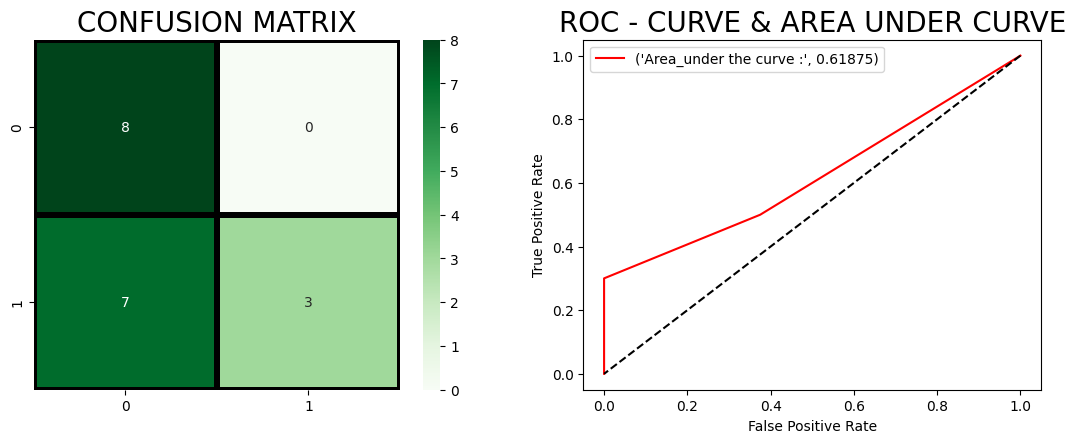

In [55]:
#XB Boost
xgb_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=3,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=40, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

xgb_model.fit(X_train_ov,y_train_ov)

prediction=xgb_model.predict(X_test_pca)

acc_xgb = accuracy_score(prediction,y_test)
print('Validation accuracy of XG Boost is', acc_xgb)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="Greens",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = xgb_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

Validation accuracy of Naive Bayes is 0.9444444444444444

Classification report :
               precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.90      0.95        10

    accuracy                           0.94        18
   macro avg       0.94      0.95      0.94        18
weighted avg       0.95      0.94      0.94        18



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

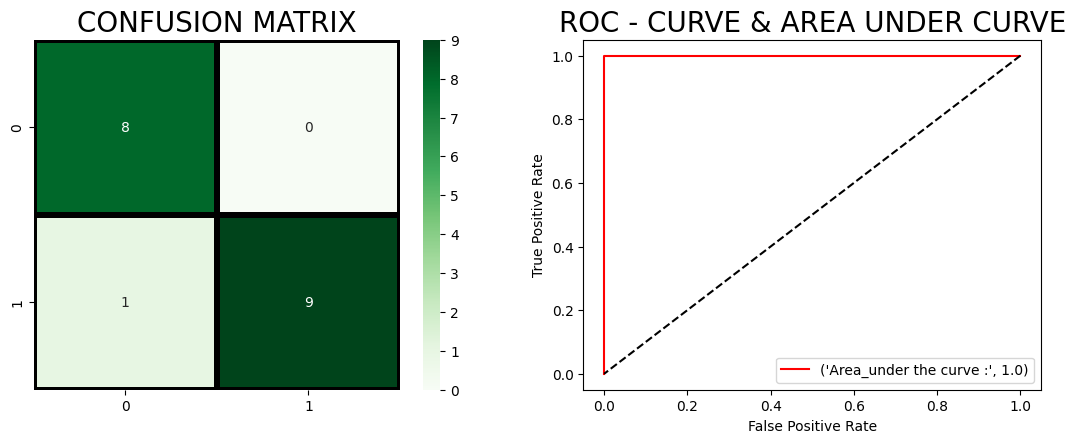

In [56]:
from sklearn.naive_bayes import GaussianNB
#In case of naive Bayes, there isn't a hyper-parameter to tune, so you have nothing to grid search over.
nb_model = GaussianNB()

nb_model.fit(X_train_ov,y_train_ov)

prediction=nb_model.predict(X_test_pca)

acc_nb = accuracy_score(prediction,y_test)
print('Validation accuracy of Naive Bayes is', acc_nb)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="Greens",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = nb_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

In [57]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 'Decision Tree',
              'Random Forest', 'XG Boost', 'Naive Bayes'],

    'Score': [acc_svc, acc_knn, acc_log, acc_decision_tree,
              acc_random_forest, acc_xgb, acc_nb]})
models.sort_values(by='Score', ascending=False)

,Model,Score
6,Naive Bayes,0.944444
2,Logistic Regression,0.833333
0,Support Vector Machines,0.722222
1,KNN,0.611111
3,Decision Tree,0.611111
5,XG Boost,0.611111
4,Random Forest,0.555556


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['Score'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_1, *['Score'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_2, *['Model'], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_3, *['Score', 'Model'], **{'inner': 'stick'})
chart